# Data Exploration: Amazon Reviews

In [ ]:
using DataFrames
using Arrow
using Printf
using StatsBase: mean, sample, percentile
using Random
using Revise
using Plots
using Unicode

In [ ]:
include("utilities.jl")

preprocess (generic function with 1 method)

## Download data

Run `python amazon_download_reviews.py`.

Requires Python and the `datasets` package by HuggingFace.

## Load data

In [ ]:
path = "datasets\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
fingerprint = readdir(path)[1]
filepath = joinpath(path, fingerprint, file_train)
df = DataFrame(Arrow.Table(filepath))

fingerprint = readdir(path)[1]
filepath = joinpath(path, fingerprint, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

## Data exploration

In [ ]:
names(df)

8-element Vector{String}:
 "review_id"
 "product_id"
 "reviewer_id"
 "stars"
 "review_body"
 "review_title"
 "language"
 "product_category"

In [ ]:
first(df, 5)

Row,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
,String?,String?,String?,Int32?,String?,String?,String?,String?
1,en_0964290,product_en_0740675,reviewer_en_0342986,1,"Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...,en,furniture
2,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing... got me,Not use able,en,home_improvement
3,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and it was broke so I ordered it again. The second one was broke in more places than the first. I can't blame the shipping process as it's shrink wrapped and boxed.,The product is junk.,en,home
4,en_0044972,product_en_0444063,reviewer_en_0656967,1,"This product is a piece of shit. Do not buy. Doesn't work, and then I try to call for customer support, it won't take my number. Fucking rip off!",Fucking waste of money,en,wireless
5,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct and couldn't get bubbles out (better without),bubble,en,pc


### Samples per star

In [ ]:
labels = df[:, "stars"];

In [ ]:
n = length(labels)
nshow = 3
for stars in 1:5
    println(stars)
    idxs  = (1:n)[labels .== stars] 
    for idx in sample(idxs, nshow)
        println("$(idx): ", df[idx, "review_body"], "\n", "-"^70)
    end
    println("")
end

1
26933: Horrible bitter tasting coffee, nothing like you get in the grocery store. Wasted my money!
----------------------------------------------------------------------
15173: The pad #50 and #100 were worn in less than 4 min
----------------------------------------------------------------------
2851: STALE! Hard as a rock! Do not buy these! I order these once a month and twice so far the package has been old. And the worst part is the item is not eligible for return.
----------------------------------------------------------------------

2
53674: Takes for ever contact cooking only, has no convection or thermal characteristics
----------------------------------------------------------------------
59616: The handle broke off after 2 months.
----------------------------------------------------------------------
40027: Took out the watch and everything was fine but nothing on it is working, not the small hands i cant even change the date on it either. What am i supposed to do with a b

star frequencies

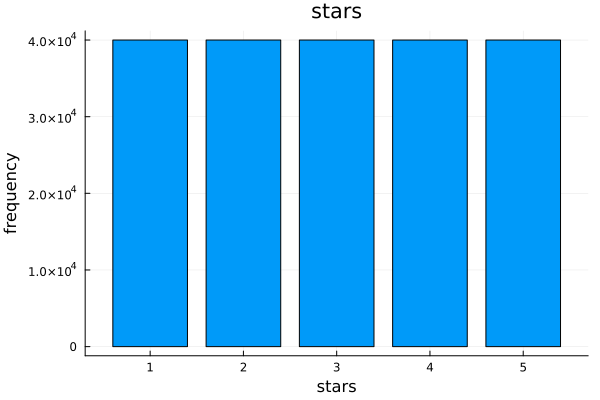

In [ ]:
x = 1:5
y = [sum(labels .== l) for l in x]
bar(x, y, xlabel="stars", ylabel="frequency", title="stars", label="")

### Other features

In [ ]:
languages = unique(df[:, :language])

1-element Vector{Union{Missing, String}}:
 "en"

In [ ]:
products = unique(df[!, :product_category])

31-element Vector{Union{Missing, String}}:
 "furniture"
 "home_improvement"
 "home"
 "wireless"
 "pc"
 "industrial_supplies"
 "kitchen"
 "apparel"
 "automotive"
 "camera"
 "lawn_and_garden"
 "watch"
 "beauty"
 ⋮
 "jewelry"
 "sports"
 "other"
 "baby_product"
 "video_games"
 "office_product"
 "grocery"
 "digital_video_download"
 "luggage"
 "shoes"
 "musical_instruments"
 "personal_care_appliances"

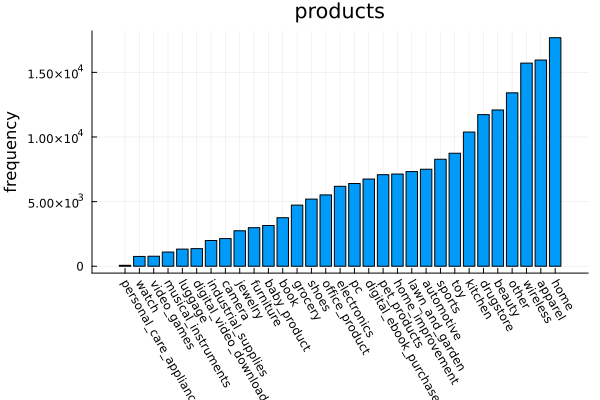

In [ ]:
x = 1:length(products)
y = [sum(df[!, :product_category] .== p) for p in products]
idxs = sortperm(y)
bar(x, y[idxs], 
    title="products", xlabel="product categories", ylabel="frequency", label="", 
    xrotation=-60, xticks=(x, products[idxs])
)

## Words

In [ ]:
pattern = r"[A-Za-z][A-Za-z]+\b" # at least 2 characters

r"[A-Za-z][A-Za-z]+\b"

In [ ]:
idx = 100
println(idx)
document = df[idx, "review_body"]
println(document, "\n")

words = preprocess(document, identity, pattern=pattern)
println("words\n", join(words, "|"), "\n")

100
I bought these bottles with the intention of mixing essential oils in them. The spray hardly works and they leak frequently. Would not recommend for use with essential oils.

words
bought|these|bottles|with|the|intention|of|mixing|essential|oils|in|them|the|spray|hardly|works|and|they|leak|frequently|would|not|recommend|for|use|with|essential|oils



In [ ]:
@time transform!(df, :review_body =>  ByRow(s -> length(s)) => :review_length);
@time transform!(df, :review_body =>  ByRow(s -> length(findall(pattern, s))) => :review_word_count);

@time transform!(df, :review_title =>  ByRow(s -> length(s)) => :review_title_length);
@time transform!(df, :review_title =>  ByRow(s -> length(findall(pattern, s))) => :review_title_word_count);

  1.914093 seconds (1.74 M allocations: 126.947 MiB, 4.07% gc time, 82.58% compilation time: 1% of which was recompilation)
  2.218883 seconds (1.16 M allocations: 353.840 MiB, 4.15% gc time, 11.03% compilation time)
  0.150330 seconds (316.55 k allocations: 15.833 MiB, 64.55% compilation time)
  0.435329 seconds (757.30 k allocations: 70.203 MiB, 30.42% compilation time)


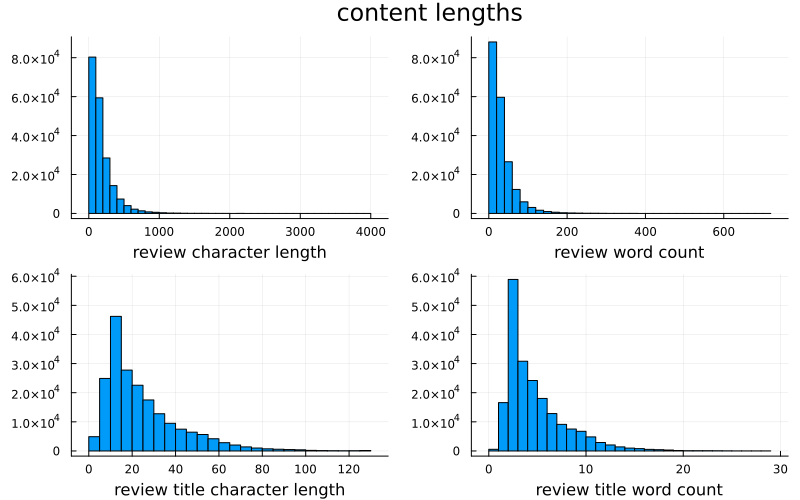

In [ ]:
p11 = histogram(df[!, :review_length], nbins=50, label="", xlabel="review character length")
p12 = histogram(df[!, :review_word_count], nbins=50,  label="", xlabel="review word count")

p21 = histogram(df[!, :review_title_length], nbins=50, label="", xlabel="review title character length")
p22 = histogram(df[!, :review_title_word_count], nbins=50,  label="", xlabel="review title word count")
plot(p11, p12, 
     p21, p22,
    layout=grid(2, 2), 
    link=:y, plot_title="content lengths", size=(800, 500))

In [ ]:
max_val, idx = findmax(df[:, :review_word_count])
println("$idx -- $max_val words")
println(df[idx, "review_body"])

145530 -- 713 words
Pros . A LOT of space. This bag can hold a ton of stuff, and it has so many pockets! Many of the pockets have elastic around the top, to better hold things like bottles and sippy cups. The main compartment has pockets all the way around the inside, and the two small pockets on the outside on either end of the bag also have elastic that allows them to expand and hold the items in securely. . I easily fit everything that's in my current diaper bag, into this bag. Including: a full 100-count pack of wipes, a handful of disposable diapers, four cloth diapers, a travel-sized wet bag, a sippy cup, a couple of extra outfits, a few toys, the travel changing pad, an entire roll of flushable cloth diaper liners, two burp cloths, a 16-oz bottle of water and a handful of small toys. I put all of that in the main compartment, leaving the waterproof pocket (which I would probably use to put dirty cloth diapers in, while also using the travel wet bag), and the “mommy pocket” empty

In [ ]:
max_val, idx = findmax(df[:, :review_title_word_count])
println("$idx -- $max_val words")
println(df[idx, "review_body"])

53252 -- 28 words
I am a dog trainer and wanted to use this for my barky dog customers. Tried it on a number of them and it didnt deter the barking.


## Tokenizers

### Load

In [ ]:
using TokenizersLite # https://github.com/LiorSinai/TokenizersLite

In [ ]:
directory = "vocab\\bpe"
path_rules = joinpath(directory, "amazon_reviews_train_en_rules.txt")
bpe = load_bpe(path_rules, startsym="⋅")

BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])

In [ ]:
directory = "vocab\\affixes"
path_vocab = joinpath(directory, "amazon_reviews_train_en_vocab.txt")
affixer = load_affix_tokenizer(path_vocab)

AffixTokenizer(length(vocab)=7179, prefixes=["un", "in"], suffixes=["s", "ed", "ing", "ly", "er", "es", "ers", "al", "ally", "ion", "en", "able", "ably", "less", "ies", "ation", "ty", "est", "ier", "ive", "ment", "ity", "ness", "ful", "or", "age", "ie", "ish", "ible", "ery", "ingly", "ant", "ical", "ance", "ative", "ous", "ties", "ary", "ist", "ated", "ial", "hood", "ify", "itive", "ition", "ise", "eous", "tion", "ious", "ate"])

In [ ]:
sentence_splitter = RuleBasedSentenceSplitter()

RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z", "C", "P", "Jul", "Eg", "Dec", "Sen", "Rev", "Mar", "BComm"  …  "E", "I", "J", "Snr", "eg", "Fri", "R", "Ms", "MBA", "Nov"]), non_breaking_numeric_prefixes=Set(["nr", "No", "pg", "Nr", "no", "p"]))

In [ ]:
tokens = bpe(words)
println("Byte-pair encoding\n", join(tokens, "|"), "\n")

tokens = affixer(words)
println("Affixer\n", join(tokens, "|"), "\n")

sentences = sentence_splitter(document)
println("Sentences\n", join(sentences, "\n"))

Byte-pair encoding
⋅bought|⋅these|⋅bottles|⋅with|⋅the|⋅intent|##ion|⋅of|⋅mixing|⋅essential|⋅oils|⋅in|⋅them|⋅the|⋅spray|⋅hardly|⋅works|⋅and|⋅they|⋅leak|⋅frequently|⋅would|⋅not|⋅recommend|⋅for|⋅use|⋅with|⋅essential|⋅oils

Affixer
bought|these|bottle|-s|with|the|intention|of|mix|-ing|essential|oil|-s|in|them|the|spray|hard|-ly|work|-s|and|they|leak|frequent|-ly|would|not|recommend|for|use|with|essential|oil|-s

Sentences
I bought these bottles with the intention of mixing essential oils in them.
The spray hardly works and they leak frequently.
Would not recommend for use with essential oils.


### Tokenizer statistics

In [ ]:
@time transform!(df, :review_body =>  ByRow(s -> length(sentence_splitter(s))) => :review_sentence_count);
@time transform!(df, :review_title =>  ByRow(s -> length(sentence_splitter(s))) => :review_title_sentence_count);

 12.595357 seconds (57.28 M allocations: 3.815 GiB, 7.40% gc time, 1.07% compilation time)
  1.957116 seconds (8.05 M allocations: 421.713 MiB, 5.34% gc time, 6.56% compilation time)


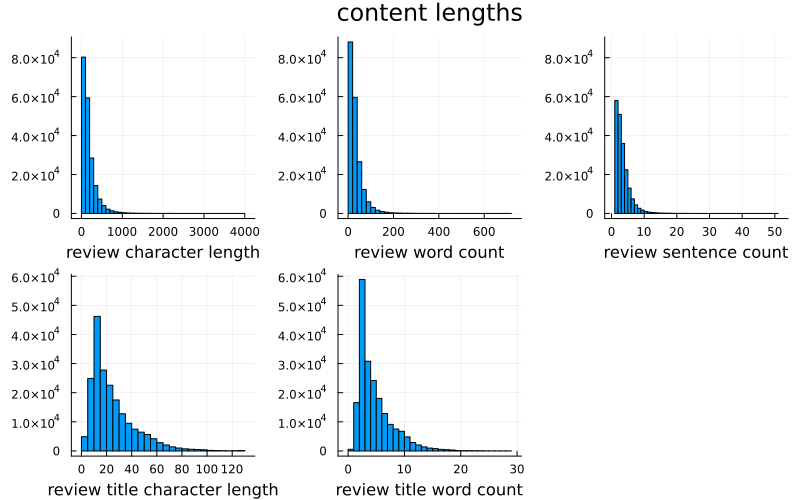

In [ ]:
p11 = histogram(df[!, :review_length], nbins=50, label="", xlabel="review character length")
p12 = histogram(df[!, :review_word_count], nbins=50,  label="", xlabel="review word count")
p13 = histogram(df[!, :review_sentence_count], nbins=50,  label="", xlabel="review sentence count")

p21 = histogram(df[!, :review_title_length], nbins=50, label="", xlabel="review title character length")
p22 = histogram(df[!, :review_title_word_count], nbins=50,  label="", xlabel="review title word count")
p23 = plot(grid=false, axis=false, ticks=false)
plot(p11, p12, p13, 
     p21, p22, p23,
    layout=grid(2, 3), 
    link=:y, plot_title="content lengths", size=(800, 500))

Token lengths

In [ ]:
@time transform!(df, :review_body =>  ByRow(s -> length(preprocess(s, bpe, pattern=pattern))) => :bpe_length);
@time transform!(df, :review_body =>  ByRow(s -> length(preprocess(s, affixer, pattern=pattern))) => :affixer_length);

 97.130998 seconds (654.43 M allocations: 17.241 GiB, 6.96% gc time, 0.69% compilation time)
 30.402786 seconds (140.25 M allocations: 5.470 GiB, 5.35% gc time, 1.54% compilation time)


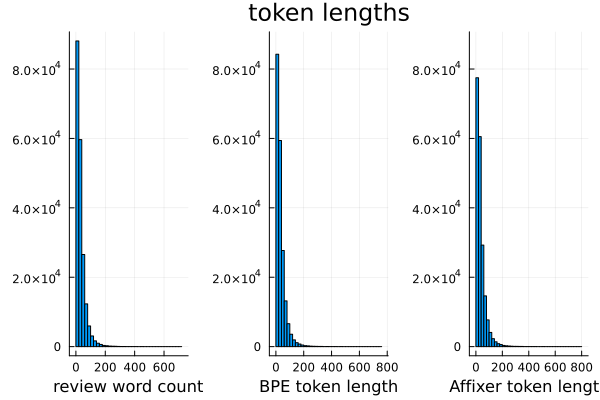

In [ ]:
p0 = histogram(df[!, :review_word_count], nbins=50,  label="", xlabel="review word count")
p1 = histogram(df[!, :bpe_length], nbins=50, label="", xlabel="BPE token length")
p2 = histogram(df[!, :affixer_length], nbins=50,  label="", xlabel="Affixer token length")
plot(p0, p1, p2, layout=grid(1, 3), link=:y, plot_title="token lengths")

In [ ]:
summary_stats = Dict{Symbol, Vector{Float64}}()
for metric in [:review_sentence_count, :review_word_count, :bpe_length, :affixer_length]
    stats_metric = zeros(7)
    stats_metric[1] = mean(df[:, metric])
    
    for (idx, threshold) in enumerate([25, 50, 75, 95, 99, 100])
        stats_metric[idx + 1] = percentile(df[:, metric], threshold)
        #@printf "%3d%% - %3d\n" p threshold
    end
    summary_stats[metric] = stats_metric
end

In [ ]:
@printf("%-21s  %s   %3d  %3d  %3d  %3d  %3d  %3d\n", "metric", "mean", 25, 50, 75, 95, 99, 100)
for metric in [:review_sentence_count, :review_word_count, :bpe_length, :affixer_length]
    @printf("%-21s  %5.2f  %3d  %3d  %3d  %3d  %3d  %3d\n", metric, summary_stats[metric]...)
end

metric                 mean    25   50   75   95   99  100
review_sentence_count   2.90    1    2    4    7   11   50
review_word_count      31.84   12   22   41   89  154  713
bpe_length             33.61   12   23   43   95  165  753
affixer_length         36.11   13   25   46  101  175  788


### Word counts per sentences

Longest review by sentence count

In [ ]:
max_val, idx = findmax(df[:, :review_sentence_count])
for (i, s) in enumerate(sentence_splitter(df[idx, :review_body]))
    println(i, " ", s)
end

1 Alright.
2 Third case for my new Note 8.
3 The first one I ordered offered NO protection.
4 The second one had AWESOME protection and looked great but the buttons were heck to push and the stylus wouldn't come out.
5 THIS GUY: Looks great.
6 I bought the gold case.
7 I'm not generally a gold person.
8 I'm fairly safe and go with black usually.
9 But I took a risk and I'm glad I did.
10 Super sharp.
11 For men AND women.
12 Not shiny or sparkly.
13 Just a metallic/sharp style.
14 Although it's a hard case, it DOES have slight cushion.
15 I'm fairly darn certain my phone will survive if I drop it.
16 My biggest worry and stress for purchasing a case is dropping my precious buddy.
17 I'm not as certain with this case as I've been with other cases, however.
18 The Note 8 has a curved screen, which I'm not a fan of.
19 I think it's gimmicky and prefer practical over presence.
20 This case does not wrap around the curves.
21 They are exposed.
22 IF you drop your phone just right and it hap

In [ ]:
sentence_lengths = Int64[]
longest_sentence = ""
longest_sentence_count = 0
all_sentences = String[]
idx_longest = 0
for (idx, row) in enumerate(eachrow(df))
    text = row[:review_body]
    sentences = sentence_splitter(text)
    push!(all_sentences, sentences...)
    for s in sentences
        words = findall(pattern, s)
        push!(sentence_lengths, length(words))
        if length(words) > longest_sentence_count
            longest_sentence_count = length(words)
            longest_sentence = s
            idx_longest = idx
        end
    end
end

In [ ]:
print(longest_sentence_count, " " , df[idx_longest, :review_body])

211 Great book to know about the learning of accelerate and great book on getting the hang of, planning for learning, and making a decent mental and physical condition for essentially what is fulfilling your objectives and as the creator notes, learning is the thing that opens your life, however it won't not be what gets you there and that is alright and book has many very good thoughts provoking and eye-opening points and there are so many books out there but this one is worth each penny and this book is easy to follow and can be applied almost immediately and the summary behind each chapter provides a quick reference guide to the detail involved and if you wish to learn or teach others to learn faster and don't have much time to read and this book is for you and the author pointed out some of the most practical terms and aspects how we can understand our memory working procedure as the way we needed to increase the skills and most importantly although the author writes this book from

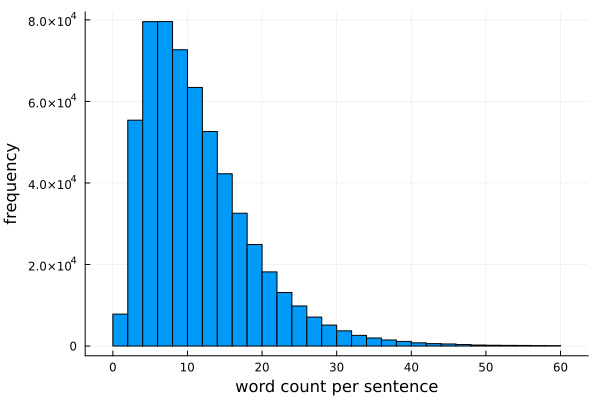

In [ ]:
histogram(sentence_lengths[sentence_lengths .< 60], 
    nbins=50,  
    label="", xlabel="word count per sentence", 
    ylabel="frequency")

In [ ]:
@show mean(sentence_lengths)
for p in [25, 50, 75, 95, 99, 100] 
    threshold = percentile(sentence_lengths, p)
    @printf "%3d%% - %4d\n" p threshold
end

mean(sentence_lengths) = 10.996912082427366
 25% -    6
 50% -    9
 75% -   15
 95% -   25
 99% -   36
100% -  211
